# Far-field displacements of a double-couple point source
_Computational Seismology, Igel (2016)_ <br>
Exercise 2.27

_Use the equation_ 

$$\begin{align}
u(\vec{x}, t) &= \frac{1}{4\pi\rho\alpha^3} \vec{A}^{FP} \frac{1}{r} \dot{M}_0 (t-\frac{r}{\alpha}) + \frac{1}{4\pi\rho\beta^3} \vec{A}^{FS} \frac{1}{r} \dot{M}_0 (t-\frac{r}{\beta}), \\
\vec{A}^{FP} &= sin(2\theta)cos(\phi) \; \hat{r} \\
\vec{A}^{FS} &= cos(2\theta)cos(\phi) \; \hat{\theta} - cos(\theta)sin(\phi) \; \hat{\phi}
\end{align}$$

_to write a program for_ far-field _Green's functions in arbitrary directions. Investigate the radiation pattern and polarization behavior of body waves._

I'll calculate $u$ at a constant $r$ and at one point in time $t=t_{peak}$ (see definition below).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import cm

In [2]:
rho = 1.4
vp = 6
vs = 4

dt = .01                           # time step
t = np.arange(0, 50, dt)           # time array
r = 1000                           # choose a large r for far field
n_step = 200                       # number of steps
phi = np.linspace(0, 2*np.pi, n_step)
theta = np.linspace(0, np.pi, n_step)

# make grid for 3D plotting later
PHI, THETA = np.meshgrid(phi, theta)

#### Define $\dot{M}_0$, $\dot{M}_{0, peak}$, and $t_{peak}$

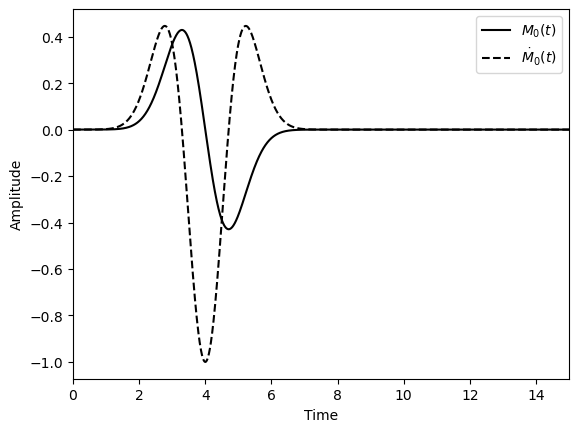

In [3]:
def gaussian(t, t0, b,  A=1):
    return -A*(t-t0)*np.exp(-((t - t0)/b)**2)

def dt_M0(t, t0, b, A=1):
    return A*np.exp(-((t - t0)/b)**2) * (2*((t-t0)**2)/b**2 - 1)

M0 = gaussian(t, 4, 1)   # define source time function
dt_M0 = dt_M0(t, 4, 1)   # get time derivative


# visualize M0 and its derivative:
plt.plot(t, M0, '-k', label = '$M_0(t)$')
plt.plot(t, dt_M0, '--k', label = r'$\dot{M}_0(t)$')
plt.xlim([0,15])
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend();

We will plot our radiation patterns for a given time snapshot. Let's choose the $t$ where $M_0$ is at a max.

In [4]:
M0_peak = max(M0)
index_max = max(range(len(t)), key=M0.__getitem__)
t_peak = t[index_max]
dt_M0_peak = dt_M0[index_max]

#### Calculate amplitudes of $u_P$ and $u_S$
Here's what the P- and S-wave contributions to $u$ look like:

$$u_P(r, \phi, \theta, t) = u_r$$
$$u_S(r, \phi, \theta, t) = u_\phi + u_\theta$$

Let's rewrite $u$ in a way that separates out its components:

$$ \begin{align}
u(r, \phi, \theta, t) = &\frac{\dot{M_0}}{4\pi\rho r} \times  \\
\bigg[& \frac{t - \frac{r}{\alpha}}{r\alpha^3} sin(2\theta)cos(\phi) \; \hat{r} \\
+& \frac{t - \frac{r}{\beta}}{r\beta^3}cos(2\theta)cos(\phi) \; \hat{\theta} \\
-& \frac{t - \frac{r}{\beta}}{r\beta^3}cos(\theta)sin(\phi) \; \hat{\phi} \bigg] \\
\end{align} $$

The amplitudes of $u_P$ and $u_S$ are
$$|u_P| = \sqrt{u_r^2}$$
$$|u_S| = \sqrt{u_\phi^2 + u_\theta^2}.$$




#### Plot radiation patterns

In [5]:
# functions for calculating displacements
def get_u_r(r, phi, theta, t, rho, vp, vs, dt_M0):
    return dt_M0*(t-r/vp) * (np.sin(2*theta)*np.cos(phi)) / (4*np.pi*rho*r*vp**3)

def get_u_theta(r, phi, theta, t, rho, vp, vs, dt_M0):
    return dt_M0*(t-r/vs) * (np.cos(2*theta)*np.cos(phi)) / (4*np.pi*rho*r*vs**3)
    
def get_u_phi(r, phi, theta, t, rho, vp, vs, dt_M0):
    return dt_M0*(t-r/vs) * (-np.cos(theta)*np.sin(phi))  / (4*np.pi*rho*r*vs**3)

# coordinate transform
def to_cartesian(r, phi, theta):
    x = r*np.sin(theta)*np.cos(phi)
    y = r*np.sin(theta)*np.sin(phi)
    z = r*np.cos(theta)
    return [x, y, z]

# get amplitudes of u
u_p = get_u_r(r, PHI, THETA, t_peak, rho, vp, vs, dt_M0_peak)
u_s = np.sqrt(get_u_theta(r, PHI, THETA, t_peak, rho, vp, vs, dt_M0_peak)**2 + get_u_phi(r, PHI, THETA, t_peak, rho, vp, vs, dt_M0_peak)**2)

# do coordinate transforms
x_p, y_p, z_p = to_cartesian(u_p, PHI, THETA)
x_s, y_s, z_s = to_cartesian(u_s, PHI, THETA)

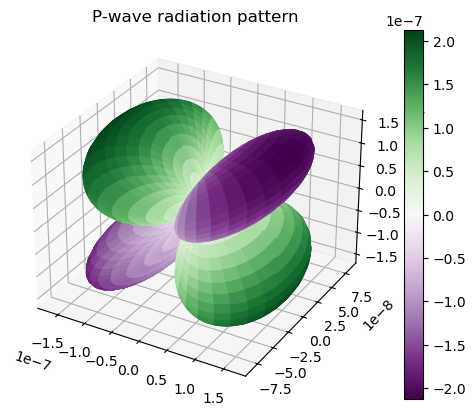

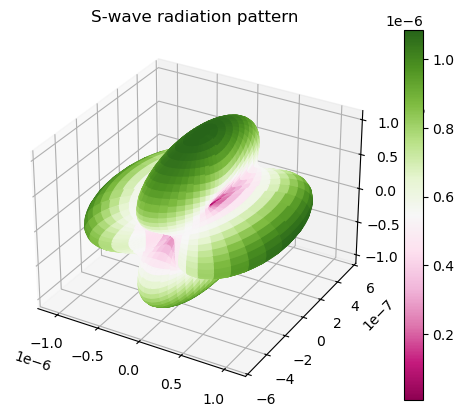

In [6]:
# P-wave pattern
fig2 = plt.figure()
ax2 = fig2.add_subplot(projection='3d')
norm = colors.Normalize(vmin = np.min(u_p), vmax = np.max(u_p))
surface_p = ax2.plot_surface(x_p, y_p, z_p, cmap = 'PRGn', facecolors = cm.PRGn(norm(u_p)))
cbar = fig2.colorbar(plt.cm.ScalarMappable(cmap = 'PRGn', norm = norm), ax = ax2)
ax2.set_title('P-wave radiation pattern')

# S-wave pattern
fig3 = plt.figure()
ax3 = fig3.add_subplot(projection='3d')
norm = colors.Normalize(vmin = np.min(u_s), vmax = np.max(u_s))
surface_p = ax3.plot_surface(x_s, y_s, z_s, cmap = 'PiYG', facecolors = cm.PiYG(norm(u_s)))
cbar = fig3.colorbar(plt.cm.ScalarMappable(cmap = 'PiYG', norm = norm), ax = ax3)
ax3.set_title('S-wave radiation pattern');
